# SYDE 556/750 --- Assignment 2

**Student ID: 00000000**

_Note:_ Please include your numerical student ID only, do _not_ include your name.

_Note:_ Refer to the [PDF](https://github.com/tcstewar/syde556-f21/raw/master/assignments/assignment_02/syde556_assignment_02.pdf) for the full instructions (including some hints), this notebook contains abbreviated instructions only. Cells you need to fill out are marked with a "writing hand" symbol. Of course, you can add new cells in between the instructions, but please leave the instructions intact to facilitate marking.


In [2040]:
# Import numpy and matplotlib -- you shouldn't need any other libraries
import numpy as np
from numpy import fft
import matplotlib.pyplot as plt

# Fix the numpy random seed for reproducible results
s = 18945
np.random.seed(s)

# Some formating options
%config InlineBackend.figure_formats = ['svg']

# 1. Generating a random input signal

## 1.1 Band-limited white noise

**a) Time-domain signals.** Plot $x(t)$ for three randomly generated signals with $\texttt{limit}$ at $5$, $10$, and $20\,\mathrm{Hz}$. For each of these, $\mathtt{T}=1\,\mathrm{s}$, $\mathtt{dt}=1\,\mathrm{ms}$ and $\mathtt{rms}=0.5$.


In [2041]:
# SETUP
def signal_rms(signal):
    return np.sqrt(np.mean(np.power(signal, 2)))


def im_rand():
    return np.random.normal() + np.random.normal() * 1j


def symmetry_exists(f, F):
    neg = -f
    return neg in F and f != 0, np.where(F == neg)


def locations(index):
    return int(index[0])


def rescale(signal, ideal_rms):
    cur_rms = signal_rms(signal)
    rescaled_signal = [p * ideal_rms / cur_rms for p in signal]
    return rescaled_signal


def zippify(F, Z):
    return (list(tt) for tt in zip(*sorted(zip(F, Z))))


def generate_signal(T, dt, rms, limit, seed):
    if seed != 0:
        np.random.seed(int(seed))
    # generate a times scale
    timescale = np.arange(0, T, dt)
    # get the number of points so that we can create a signal in the frequency domain
    num_pts = len(timescale)
    # convert to frequency domain
    F = fft.fftfreq(num_pts, dt)
    # create a frequenct signal of zeros
    length_F = len(F)
    # create zeros for the frequency domain
    zeros = np.zeros(length_F)
    Z = zeros.tolist()

    for idx, f in enumerate(F):
        if Z[idx] == 0:
            magnitude_f = abs(f)
            if magnitude_f <= limit:
                im = im_rand()
                Z[idx] = im
                # ensure that we account for the negative symmetric value
                exists, index = symmetry_exists(f, F)
                if exists:
                    location = locations(index)
                    # assig it to the complex conjugate
                    Z[location] = np.conj(im)
        else:
            continue
    # perform inverse fft
    z = fft.ifft(Z)
    # select the real components
    z = z.real
    # rescale based on the current and ideal rmse
    z = rescale(z, rms)

    # convert back to frequency domain
    Z = fft.fft(z)
    # touple Z so that it aligns with our intial number of samples
    F, Z = zippify(F, Z)
    return z, Z


def plot_signal(signal, domain="time", T=1, dt=1 / 1000, show_rmse=True):
    t = np.arange(0, T, dt)
    if domain == "time":
        plt.figure()
        plt.plot(t, signal["x"])
        plt.suptitle(
            "$x(t)$ signal with " + str(signal["freq"]) + " Hz limit",
        )
        plt.xlabel("$t$ sec.")
        plt.ylabel("$x(t)$")
        plt.show()
        if show_rmse:
            print("time-domain RMSE " + str(np.round(signal_rms(signal["x"]), 3)))
    if domain == "frequency":
        plt.figure()
        plt.plot(t, signal["X"])
        plt.suptitle(
            "$x(\omega)$ signal with " + str(signal["freq"]) + " Hz limit",
        )
        plt.xlabel("$w$ Hz.")
        plt.ylabel("$x(\omega)$")
        plt.show()
        if show_rmse:
            print("frequency-domain RMSE " + str(np.round(signal_rms(signal["X"]), 3)))

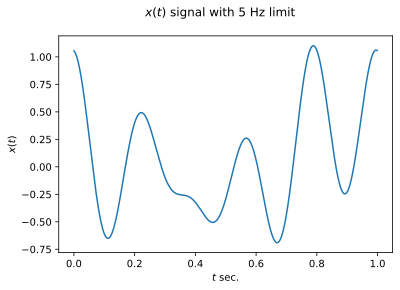

time-domain RMSE 0.5


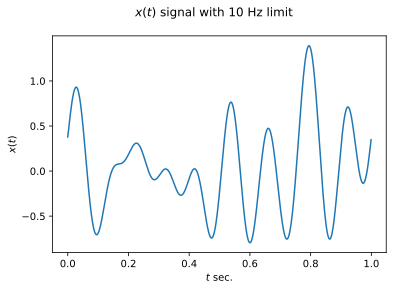

time-domain RMSE 0.5


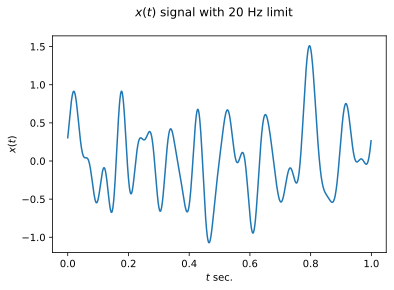

time-domain RMSE 0.5


In [2042]:
signals = []
limits = [5, 10, 20]
T = 1
dt = 1 / 1000
rms = 0.5
# Generate signals and store in list called signals as dictionaries
for limit in limits:
    x, X = generate_signal(T, dt, rms, limit, s)
    signal = {"x": x, "X": X, "freq": limit}
    signals.append(signal)

for signal in signals:
    plot_signal(signal, domain="time", T=T, dt=dt, show_rmse=True)

**b) Average power spectrum.** Plot the average $|X(\omega)|$ (the norm of the Fourier coefficients, or “power spectrum”) over $100$ signals generated with $\mathtt{T}=1\,\mathrm{s}$, $\mathtt{dt}=1\,\mathrm{ms}$, $\mathtt{rms}=0.5$, and $\mathtt{limit}=10\,\mathrm{Hz}$ (of course, each of these 100 signals should have a different `seed`). The plot should have the $x$-axis labeled “$\omega$ in radians” and the average $|X|$ value for that $\omega$ on the $y$-axis.


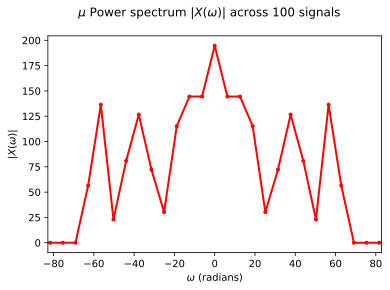

In [2043]:
num_signals = 100

signals = []
limit = 10
T = 1
dt = 1 / 1000
rms = 0.5
random_seeds = np.zeros(num_signals)


def norm(Xs):
    return [
        np.absolute(freq_vals)
        for freq_vals in Xs[
            :,
        ]
    ][0]


for idx, seed in enumerate(random_seeds):
    random_seeds[idx] = int(np.random.randint(1111, 9999))

frequency_signals = []

for lseed in random_seeds:
    x, X = generate_signal(T, dt, rms, limit, lseed)
    signal = {"x": x, "X": X, "freq": limit}
    frequency_signals.append(X)
    signals.append(signal)

timescale = np.arange(0, T, dt)
# get the number of points so that we can create a signal in the frequency domain
num_pts = len(timescale)
# convert to frequency domain
F = sorted(fft.fftfreq(num_pts, dt))

# conver to rad/s
F = np.array(F)
W = F * 2 * np.pi
W = W.tolist()
endpoints = [-2 * np.pi * limit - 20, 2 * np.pi * limit + 20]
frequency_signals = np.array(frequency_signals)
norms = norm(frequency_signals)
plt.figure()
plt.suptitle(
    "$\mu$ Power spectrum $|X(\omega)|$ across " + str(num_signals) + " signals"
)
plt.plot(W, norms, "r", linewidth=2,marker=".")
plt.xlabel("$\omega$ (radians)")
plt.ylabel("$|X(\omega)|$")
plt.xlim(endpoints)
plt.show()

## 1.2 Gaussian power spectrum noise

**a) Time-domain signals.** Plot $x(t)$ for three randomly generated signals with `bandwidth` at $5$, $10$, and $20\,\mathrm{Hz}$. For each of these, $\mathtt{T}=1\,\mathrm{s}$, $\mathtt{dt}=1\,\mathrm{ms}$ and $\mathtt{rms}=0.5$.


In [2044]:
# ✍ <YOUR SOLUTION HERE>

**b) Average power spectrum.** Plot the average $|X(\omega)|$ (the norm of the Fourier coefficients, or “power spectrum”) over $100$ signals generated with $\mathtt{T}=1\,\mathrm{s}$, $\mathtt{dt}=1\,\mathrm{ms}$, $\mathtt{rms}=0.5$, and $\mathtt{bandwidth}=10$ (of course, each of these 100 signals should have a different `seed`). The plot should have the $x$-axis labeled “$\omega$ in radians” and the average $|X|$ value for that $\omega$ on the $y$-axis.


In [2045]:
# ✍ <YOUR SOLUTION HERE>

# 2. Simulating a spiking neuron

**a) Spike plots for constant inputs.** Plot the spike output for a constant input of $x=0$ over $1$ second. Report the number of spikes. Do the same thing for $x=1$. Use a time step of $\Delta t = 1\,\mathrm{ms}$ for the simulation.


In [2046]:
# ✍ <YOUR SOLUTION HERE>

**b) Discussion.** Does the observed number of spikes in the previous part match the expected number of spikes for $x=0$ and $x=1$? Why or why not? What aspects of the simulation would affect this accuracy?


✍ \<YOUR SOLUTION HERE\>


**c) Spike plots for white noise inputs.** Plot the spike output for $x(t)$ generated using your function from part 1.1. Use $\mathtt{T}=1\,\mathrm{s}$, $\mathtt{dt}=1\,\mathrm{ms}$, $\mathtt{rms}=0.5$, and $\mathtt{limit}=30\,\mathrm{Hz}$. Overlay on this plot $x(t)$.


In [2047]:
# ✍ <YOUR SOLUTION HERE>

**d) Voltage over time.** Using the same $x(t)$ signal as in part _c)_, plot the neuron's voltage over time for the first $0.2$ seconds, along with the spikes over the same time.


In [2048]:
# ✍ <YOUR SOLUTION HERE>

**e) 🌟 Bonus question.** How could you improve this simulation (in terms of how closely the model matches actual equation) without significantly increasing the computation time? $0.5$ marks for having a good idea. Up to $1$ mark for actually implementing it and showing that it works.


✍ \<YOUR SOLUTION HERE\>


In [2049]:
# ✍ <YOUR SOLUTION HERE>

# 3. Simulating two spiking neurons

**a) Spike plots for constant inputs.** Plot $x(t)$ and the spiking output for $x(t)=0$ (both neurons should spike at about $40$ spikes per second), as well as (in a separate plot) $x(t)=1$ (one neuron should spike at $\approx 150$ spikes per second, and the other should not spike at all).


In [2050]:
# ✍ <YOUR SOLUTION HERE>

**b) Spike plots for a sinusodial input.** Plot $x(t)$ and the spiking output for $x(t)=\frac{1}2 \sin(10 \pi t)$.


In [2051]:
# ✍ <YOUR SOLUTION HERE>

**c) Spike plot for a white noise signal.** Plot $x(t)$ and the spiking output for a random signal generated with your function for question 1.1 with $\mathtt{T}=2\,\mathrm{s}$, $\mathtt{dt}=1\,\mathrm{ms}$, $\mathtt{rms}=0.5$, and $\mathtt{limit}=5\,\mathrm{Hz}$.


In [2052]:
# ✍ <YOUR SOLUTION HERE>

# 4. Computing an optimal filter

**a) Document the code.** Fill in comments where there are `# !`-signs in the Python code. Make sure that your comments (where this makes sense) describe the semantics of the code and do not just repeat what is obvious from the code itself. Run the function with what you wrote for part 3 above, so that it uses the spike signal generated in 3c).


In [2053]:
def compute_optimal_filter(
    # Signal generated from your white noise generator
    x,
    # Fourier coefficients from your white noise generator
    X,
    # Spike train from the previous part
    spikes,
    # Time step size
    dt=1e-3,
):

    # x and X should (effectively) be 1D-arrays
    assert x.ndim == 1 and X.ndim == 1
    assert x.shape[0] == X.shape[0]

    # !
    Nt = x.size

    # Make sure that "spikes" is a 2 x Nt array
    assert spikes.ndim == 2
    assert spikes.shape[0] == 2
    assert spikes.shape[1] == Nt

    # !
    T = Nt * dt

    # !
    ts = np.arange(Nt) * dt - T / 2.0

    # !
    fs = np.arange(Nt) / T - Nt / (2.0 * T)

    # !
    omega = fs * 2.0 * np.pi

    # !
    r = spikes[0] - spikes[1]

    # !
    R = np.fft.fftshift(np.fft.fft(r))

    # !
    sigma_t = 25e-3

    # !
    W2 = np.exp(-(omega**2) * sigma_t**2)

    # !
    W2 = W2 / sum(W2)

    # !
    CP = X * R.conjugate()

    # !
    WCP = np.convolve(CP, W2, "same")

    # !
    RP = R * R.conjugate()

    # !
    WRP = np.convolve(RP, W2, "same")

    # !
    XP = X * X.conjugate()

    # !
    WXP = np.convolve(XP, W2, "same")

    # !
    H = WCP / WRP

    # !
    h = np.fft.fftshift(np.fft.ifft(np.fft.ifftshift(H))).real

    # !
    XHAT = H * R

    # !
    xhat = np.fft.ifft(np.fft.ifftshift(XHAT)).real

    return ts, fs, R, H, h, XHAT, xhat, XP, WXP

**b) Optimal filter.** Plot the time and frequency plots of the optimal filter for the signal you generated in question 3c). Make sure to use appropriate limits for the $x$-axis.


In [2054]:
# ✍ <YOUR SOLUTION HERE>

**c) Decoded signal.** Plot the $x(t)$ signal, the spikes, and the decoded $\hat x(t)$ value for the signal from 3c).


In [2055]:
# ✍ <YOUR SOLUTION HERE>

**d) Power spectra.** Plot the signal $|X(\omega)|$, spike response $|R(\omega)|$, and filtered signal $|\hat X(\omega)|$ power spectra for the signal from 3c).


In [2056]:
# ✍ <YOUR SOLUTION HERE>

**e) Discussion.** How do these spectra relate to the optimal filter?


✍ \<YOUR SOLUTION HERE\>


**f) Filter for different signal bandwidths.** Plot the optmial filter $h(t)$ in the time domain when filtering spike trains for white noise signals with different `limit` values of $2\,\mathrm{Hz}$, $10\,\mathrm{Hz}$, and $30\,\mathrm{Hz}$.


In [2057]:
# ✍ <YOUR SOLUTION HERE>

**g) Discussion.** Describe the effects on the time plot of the optimal filter as `limit` increases. Why does this happen?


✍ \<YOUR SOLUTION HERE\>


# Using post-synaptic currents as a filter

**a) Plotting the filter for different $n$.** Plot the normalized $h(t)$ for $n=0$, $1$, and $2$, with $\tau=7\,\mathrm{ms}$.


In [2058]:
# ✍ <YOUR SOLUTION HERE>

**b) Discussion.** What two things do you expect increasing $n$ will do to $\hat{x}(t)$?


✍ \<YOUR SOLUTION HERE\>


**c) Plotting the filter for different $\tau$.** Plot the normalized $h(t)$ for $\tau=2\,\mathrm{ms}$, $\tau=5\,\mathrm{ms}$, $\tau=10\,\mathrm{ms}$, $\tau=20\,\mathrm{ms}$ with $n = 0$.


In [2059]:
# ✍ <YOUR SOLUTION HERE>

**d) Discussion.** What two things do you expect increasing $\tau$ will do to $\hat{x}(t)$?


✍ \<YOUR SOLUTION HERE\>


**e) Decoding a spike-train using the post-synaptic current filter.** Decode $\hat{x}(t)$ from the spikes generated in question 3c) using an $h(t)$ with $n=0$ and $\tau=7\,\mathrm{ms}$. Do this by generating the spikes, filtering them with $h(t)$, and using that as your activity matrix $A$ to compute your decoders. Plot the time and frequency plots for this $h(t)$. Plot the $x(t)$ signal, the spikes, and the decoded $\hat{x}(t)$ value.


In [2060]:
# ✍ <YOUR SOLUTION HERE>

**f) Deocding a spike-train representing a low-frequency signal.** Use the same decoder and $h(t)$ as in part e), but generate a new $x(t)$ with $\mathtt{limit}=2\,\mathrm{Hz}$. Plot the $x(t)$ signal, the spikes, and the decoded $\hat{x}(t)$ value.


In [2061]:
# ✍ <YOUR SOLUTION HERE>

**g) Discussion.** How do the decodings from e) and f) compare? Explain.


✍ \<YOUR SOLUTION HERE\>
